In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
from functools import partial
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from explanations.data_enhancing import enhance_data, proc_info, melt, summ

from bioreaction.simulation.manager import simulate_steady_states
from bioreaction.simulation.simfuncs.basic_de import bioreaction_sim_expanded
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.misc.helper import vanilla_return
from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.common.testing.shared import CONFIG
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config

CONFIG = prepare_config(CONFIG)

In [3]:
fn = '../data/ensemble_mutation_effect_analysis/2023_06_05_164913/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
# data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)
# dfm = melt(data[data['sample_name'] == 'RNA_0'], num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)


## Mean & STDs

In [4]:
analytics = [c for c in get_true_names_analytics(data) if ('sensitivity' in c) or ('precision' in c)]
# agg1 = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: 'std' for c in analytics})
agg1_stds = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: lambda x: np.std(x) if sum(x) != 0.0 else 0.0 for c in analytics + ['num_interacting', 'num_self_interacting']})
agg1_mean = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: lambda x: np.mean(x) if sum(x) != 0.0 else 0.0 for c in analytics + ['num_interacting', 'num_self_interacting']})


In [5]:
agg1_stds.columns

Index(['circuit_name', 'mutation_num', 'sample_name',
       'precision_wrt_species-6',
       'precision_wrt_species-6_diff_to_base_circuit',
       'precision_wrt_species-6_ratio_from_mutation_to_base',
       'sensitivity_wrt_species-6',
       'sensitivity_wrt_species-6_diff_to_base_circuit',
       'sensitivity_wrt_species-6_ratio_from_mutation_to_base',
       'num_interacting', 'num_self_interacting'],
      dtype='object')

In [6]:
# sns.jointplot(agg1_stds, x='precision_wrt_species-6', y='sensitivity_wrt_species-6', alpha=0.1)


In [7]:
# sns.jointplot(agg1_stds, x='precision_wrt_species-6', y='sensitivity_wrt_species-6', alpha=0.1)
# plt.xscale('log')

Find joint min of precision and std differences between all circuits and max of precision STD difference

In [8]:
filts = (agg1_mean['sample_name'] == 'RNA_2') & (agg1_mean['precision_wrt_species-6'] != np.inf) & (agg1_mean['precision_wrt_species-6'] > 1) & ((agg1_mean['num_interacting'] > 1) | (agg1_mean['num_self_interacting'] > 1))

In [9]:
p = agg1_mean[filts]['precision_wrt_species-6'].to_numpy()
s = agg1_mean[filts]['sensitivity_wrt_species-6'].to_numpy()

# p = p / p.max()
# s = s / s.max()
prec_diffs = np.log(p[:, None] / p[None, :])
sens_diffs = np.log(s[:, None] / s[None, :])


In [10]:
st = agg1_stds[filts]['precision_wrt_species-6_ratio_from_mutation_to_base'].to_numpy()
# st = st / st.max()
std_diffs = np.log(st[:, None] / st[None, :])

/tmp/ipykernel_156135/4047941361.py:3: RuntimeWarning: divide by zero encountered in divide
  std_diffs = np.log(st[:, None] / st[None, :])
/tmp/ipykernel_156135/4047941361.py:3: RuntimeWarning: invalid value encountered in divide
  std_diffs = np.log(st[:, None] / st[None, :])
/tmp/ipykernel_156135/4047941361.py:3: RuntimeWarning: divide by zero encountered in log
  std_diffs = np.log(st[:, None] / st[None, :])


In [11]:
std_diffs = np.where(np.isnan(std_diffs) | (np.abs(std_diffs) == np.inf), 0, std_diffs)

In [12]:
weighting_prec = 1
weighting_sens = 0.4
joint_diffs = weighting_prec * np.abs(prec_diffs) + weighting_sens * np.abs(sens_diffs)

In [13]:
joint_diffs

array([[0.        , 1.85482751, 1.07953462, ..., 0.50484574, 2.29968483,
        0.60441918],
       [1.85482751, 0.        , 1.67280331, ..., 2.35967324, 0.58031588,
        2.22416258],
       [1.07953462, 1.67280331, 0.        , ..., 0.69426913, 1.2201502 ,
        0.55135926],
       ...,
       [0.50484574, 2.35967324, 0.69426913, ..., 0.        , 1.91441934,
        0.21915368],
       [2.29968483, 0.58031588, 1.2201502 , ..., 1.91441934, 0.        ,
        1.69526565],
       [0.60441918, 2.22416258, 0.55135926, ..., 0.21915368, 1.69526565,
        0.        ]])

In [14]:
prec_diffs

array([[ 0.        , -0.06772928,  0.44875521, ...,  0.44505562,
         0.49357833,  0.48687712],
       [ 0.06772928,  0.        ,  0.51648449, ...,  0.5127849 ,
         0.56130761,  0.5546064 ],
       [-0.44875521, -0.51648449,  0.        , ..., -0.0036996 ,
         0.04482311,  0.03812191],
       ...,
       [-0.44505562, -0.5127849 ,  0.0036996 , ...,  0.        ,
         0.04852271,  0.04182151],
       [-0.49357833, -0.56130761, -0.04482311, ..., -0.04852271,
         0.        , -0.0067012 ],
       [-0.48687712, -0.5546064 , -0.03812191, ..., -0.04182151,
         0.0067012 ,  0.        ]])

In [15]:
# del sens_diffs
# del prec_diffs

In [16]:
joint_diffs[joint_diffs != 0].min()

1.0828857548991985e-05

In [17]:
joint_diffs.max()

15.77989394055444

In [18]:
joint_diffs_rev = np.where(joint_diffs != 0, joint_diffs.max() - np.abs(joint_diffs), 0)

Flip into a maximisation problem.

In [19]:
joint = joint_diffs_rev + np.abs(std_diffs)

In [20]:
np.abs(std_diffs).max()

15.18527732397358

In [21]:
joint.max()

27.313620174364516

Get circuit indices for filtered aggregated data.

In [22]:
np.abs(joint).max()

27.313620174364516

In [23]:
circ1, circ2 = np.where(joint == np.abs(joint).max()) 
# circ1, circ2 = np.unique(circ1), np.unique(circ2)


In [24]:
circ1, circ2 = np.array(list(set([tuple(sorted([c1, c2])) for c1, c2 in zip(circ1, circ2)]))).T

In [25]:
circ1, circ2

(array([570]), array([1264]))

In [26]:
print(joint[circ1[0], circ2[0]])
print(joint_diffs_rev[circ1[0], circ2[0]])
print(joint_diffs[circ1[0], circ2[0]])
print(std_diffs[circ1[0], circ2[0]])
print(prec_diffs[circ1[0], circ2[0]])
print(sens_diffs[circ1[0], circ2[0]])

27.313620174364516
12.39259864339362
3.387295297160818
14.921021530970894
-0.5229029872645466
7.160980774740678


In [27]:

circ1_m_df = agg1_mean[filts].iloc[circ1]
circ2_m_df = agg1_mean[filts].iloc[circ2]
circ1_s_df = agg1_stds[filts].iloc[circ1]
circ2_s_df = agg1_stds[filts].iloc[circ2]

circ1_m_df

,circuit_name,mutation_num,sample_name,precision_wrt_species-6,precision_wrt_species-6_diff_to_base_circuit,precision_wrt_species-6_ratio_from_mutation_to_base,sensitivity_wrt_species-6,sensitivity_wrt_species-6_diff_to_base_circuit,sensitivity_wrt_species-6_ratio_from_mutation_to_base,num_interacting,num_self_interacting
18368,toy_circuit_combo0_505405,5,RNA_2,1769.635523,1768.708085,1908.200694,0.431516,-0.529957,0.448807,0.6,1.533333


In [28]:
circ2_m_df

,circuit_name,mutation_num,sample_name,precision_wrt_species-6,precision_wrt_species-6_diff_to_base_circuit,precision_wrt_species-6_ratio_from_mutation_to_base,sensitivity_wrt_species-6,sensitivity_wrt_species-6_diff_to_base_circuit,sensitivity_wrt_species-6_ratio_from_mutation_to_base,num_interacting,num_self_interacting
37196,toy_circuit_combo0_898227,1,RNA_2,2985.229397,1.534367,1.000514,0.000335,-1.719697e-07,0.999487,0.033333,1.1


Narrow the selection.

In [44]:
data[(data['circuit_name'] == circ1_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ1_m_df['mutation_num'].values[0]) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == circ1_m_df['sample_name'].values[0]) ][
    ['circuit_name', 'mutation_name', 'mutation_num', 'mutation_type', 'mutation_positions', 'num_interacting', 'num_self_interacting', 'precision_wrt_species-6', 'precision_wrt_species-6_diff_to_base_circuit', 'precision_wrt_species-6_ratio_from_mutation_to_base', 'sensitivity_wrt_species-6', 'sensitivity_wrt_species-6_diff_to_base_circuit', 'sensitivity_wrt_species-6_ratio_from_mutation_to_base', 'sample_name']
]

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,num_interacting,num_self_interacting,precision_wrt_species-6,precision_wrt_species-6_diff_to_base_circuit,precision_wrt_species-6_ratio_from_mutation_to_base,sensitivity_wrt_species-6,sensitivity_wrt_species-6_diff_to_base_circuit,sensitivity_wrt_species-6_ratio_from_mutation_to_base,sample_name
474737,toy_circuit_combo0_505405,RNA_0_m5-0,5,"[3, 2, 2, 11, 6]","[18, 14, 6, 17, 10]",0,1,2985.285400,2984.358000,3219.037800,0.000335,-0.961138,0.000348,RNA_2
474740,toy_circuit_combo0_505405,RNA_0_m5-1,5,"[6, 10, 1, 5, 7]","[5, 4, 14, 7, 12]",1,2,13576.084000,13575.156000,14639.112000,0.000213,-0.961260,0.000222,RNA_2
474743,toy_circuit_combo0_505405,RNA_0_m5-2,5,"[7, 7, 9, 4, 11]","[13, 2, 4, 7, 3]",0,1,2985.285400,2984.358000,3219.037800,0.000335,-0.961138,0.000348,RNA_2
474746,toy_circuit_combo0_505405,RNA_0_m5-3,5,"[0, 9, 8, 3, 8]","[0, 17, 2, 18, 13]",0,1,2985.285400,2984.358000,3219.037800,0.000335,-0.961138,0.000348,RNA_2
474749,toy_circuit_combo0_505405,RNA_0_m5-4,5,"[9, 1, 8, 11, 4]","[3, 14, 10, 1, 7]",0,1,2985.285400,2984.358000,3219.037800,0.000335,-0.961138,0.000348,RNA_2
474752,toy_circuit_combo0_505405,RNA_0_m5-5,5,"[6, 2, 8, 6, 2]","[12, 0, 9, 8, 14]",1,2,4.725396,3.798011,5.095401,0.206547,-0.754926,0.214824,RNA_2
474755,toy_circuit_combo0_505405,RNA_0_m5-6,5,"[6, 7, 8, 11, 7]","[10, 13, 2, 3, 9]",0,1,2985.285400,2984.358000,3219.037800,0.000335,-0.961138,0.000348,RNA_2
474758,toy_circuit_combo0_505405,RNA_0_m5-7,5,"[2, 7, 11, 5, 4]","[0, 8, 17, 15, 18]",1,1,0.990108,0.062724,1.067635,0.871344,-0.090129,0.906259,RNA_2
474761,toy_circuit_combo0_505405,RNA_0_m5-8,5,"[4, 6, 2, 4, 6]","[15, 13, 6, 11, 12]",0,1,2985.285400,2984.358000,3219.037800,0.000335,-0.961138,0.000348,RNA_2
474917,toy_circuit_combo0_505405,RNA_1_m5-0,5,"[0, 3, 2, 0, 7]","[10, 19, 12, 16, 15]",1,1,0.927383,-0.000001,0.999999,0.961475,0.000001,1.000001,RNA_2


In [45]:

data[(data['circuit_name'] == circ2_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ2_m_df['mutation_num'].values[0]) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == circ2_m_df['sample_name'].values[0]) ][
    ['circuit_name', 'mutation_name', 'mutation_num', 'mutation_type', 'mutation_positions', 'num_interacting', 'num_self_interacting', 'precision_wrt_species-6', 'precision_wrt_species-6_diff_to_base_circuit', 'precision_wrt_species-6_ratio_from_mutation_to_base', 'sensitivity_wrt_species-6', 'sensitivity_wrt_species-6_diff_to_base_circuit', 'sensitivity_wrt_species-6_ratio_from_mutation_to_base', 'sample_name']
]

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,num_interacting,num_self_interacting,precision_wrt_species-6,precision_wrt_species-6_diff_to_base_circuit,precision_wrt_species-6_ratio_from_mutation_to_base,sensitivity_wrt_species-6,sensitivity_wrt_species-6_diff_to_base_circuit,sensitivity_wrt_species-6_ratio_from_mutation_to_base,sample_name
961658,toy_circuit_combo0_898227,RNA_0_m1-0,1,[0],[11],0,1,2983.6950,0.000000,1.000000,0.000335,0.000000e+00,1.000000,RNA_2
961661,toy_circuit_combo0_898227,RNA_0_m1-1,1,[0],[17],0,1,2983.6950,0.000000,1.000000,0.000335,0.000000e+00,1.000000,RNA_2
961664,toy_circuit_combo0_898227,RNA_0_m1-2,1,[4],[13],0,1,2983.6950,0.000000,1.000000,0.000335,0.000000e+00,1.000000,RNA_2
961667,toy_circuit_combo0_898227,RNA_0_m1-3,1,[1],[9],0,1,2983.6950,0.000000,1.000000,0.000335,0.000000e+00,1.000000,RNA_2
961670,toy_circuit_combo0_898227,RNA_0_m1-4,1,[1],[9],0,1,2983.6950,0.000000,1.000000,0.000335,0.000000e+00,1.000000,RNA_2
961673,toy_circuit_combo0_898227,RNA_0_m1-5,1,[3],[14],0,1,2983.6950,0.000000,1.000000,0.000335,0.000000e+00,1.000000,RNA_2
961676,toy_circuit_combo0_898227,RNA_0_m1-6,1,[0],[5],0,1,2983.6950,0.000000,1.000000,0.000335,0.000000e+00,1.000000,RNA_2
961679,toy_circuit_combo0_898227,RNA_0_m1-7,1,[5],[0],0,1,2983.6950,0.000000,1.000000,0.000335,0.000000e+00,1.000000,RNA_2
961682,toy_circuit_combo0_898227,RNA_0_m1-8,1,[7],[3],0,1,2983.6950,0.000000,1.000000,0.000335,0.000000e+00,1.000000,RNA_2
961685,toy_circuit_combo0_898227,RNA_0_m1-9,1,[2],[12],0,1,2983.6950,0.000000,1.000000,0.000335,0.000000e+00,1.000000,RNA_2


In [31]:
# circuit_chosen_idx = circ1[0]
# circuit_chosen = data.iloc[circuit_chosen_idx]
# e_dir = os.path.join(fn.split('summarise')[0], 'mutation_effect_on_interactions_signal', circuit_chosen['circuit_name'], 'mutations', circuit_chosen['mutation_name'], 'energies')
# energies = pd.read_csv(os.path.join(e_dir, os.listdir(e_dir)[0]))
# print(circuit_chosen[['circuit_name', 'mutation_name']])
# energies

## Check circuits chosen

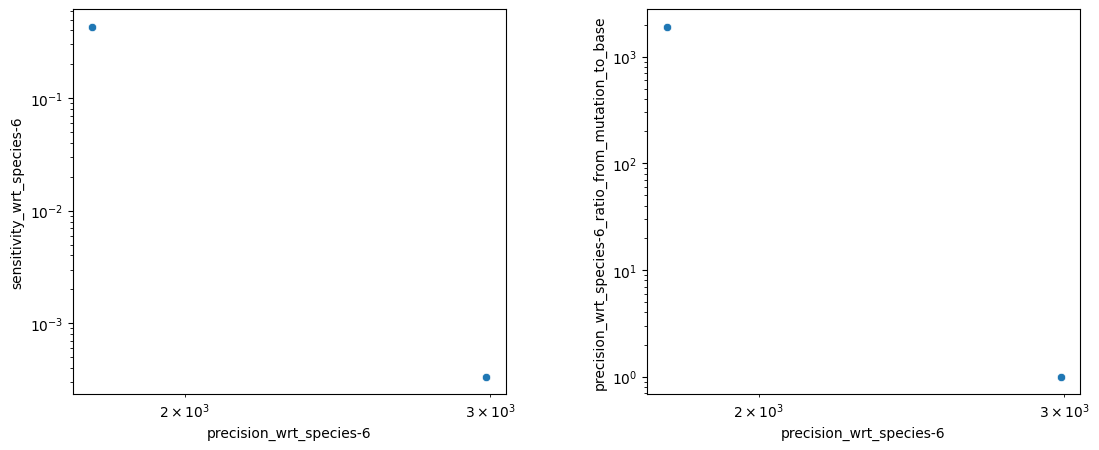

In [32]:


m_df = pd.concat([circ1_m_df, circ2_m_df])
s_df = pd.concat([circ1_m_df, circ2_m_df])

fig =plt.figure(figsize=(13, 5))
fig.subplots_adjust(wspace=0.325)

ax = plt.subplot(1,2,1)
sns.scatterplot(x=m_df['precision_wrt_species-6'], y=m_df['sensitivity_wrt_species-6'])
plt.yscale('log')
plt.xscale('log')
ax = plt.subplot(1,2,2)
sns.scatterplot(x=s_df['precision_wrt_species-6'], y=s_df['precision_wrt_species-6_ratio_from_mutation_to_base'])
plt.yscale('log')
plt.xscale('log')


Text(0.5, 1.0, 'Mean of precision vs. standard deviation in\nprecision ratio from mutation to reference circuits')

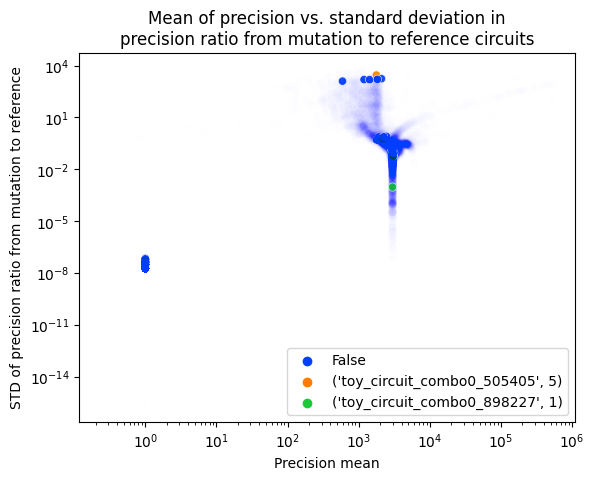

In [33]:
c1n, c1m = circ1_m_df['circuit_name'].values[0], circ1_m_df['mutation_num'].values[0]
c2n, c2m = circ2_m_df['circuit_name'].values[0], circ2_m_df['mutation_num'].values[0]
alpha = (agg1_mean[agg1_mean['precision_wrt_species-6'] < np.inf]['circuit_name'].isin(
    [c1n, c2n])).apply(lambda x: x - 0.1 if x == 1 else x + 0.005)
# hue = agg1_stds['circuit_name'].isin([circ1_df['circuit_name'].values[0], circ2_df['circuit_name'].values[0]]).apply(lambda x: 'circ1' if x else x) & \
#     agg1_stds['mutation_num'].isin([circ1_df['mutation_num'].values[0], circ2_df['mutation_num'].values[0]]).apply(lambda x: 'circ2' if x else x)
hue_d = {c1n: c1m, c2n: c2m}
hue = jax.tree_util.tree_map(lambda c, m: (c,m) if (c in [c1n, c2n]) and (m == hue_d[c]) else False, list(agg1_mean['circuit_name'].values), list(agg1_mean['mutation_num'].values))
sns.scatterplot(x=agg1_mean['precision_wrt_species-6'], y=agg1_stds['precision_wrt_species-6_ratio_from_mutation_to_base'], 
                alpha=alpha,
                hue=hue,
                palette='bright')
plt.xlabel('Precision mean')
plt.ylabel('STD of precision ratio from mutation to reference')
plt.xscale('log')
plt.yscale('log')
plt.title('Mean of precision vs. standard deviation in\nprecision ratio from mutation to reference circuits')

In [34]:
np.log10(agg1_mean[(agg1_mean['circuit_name'].isin([c1n, c2n])) & (agg1_mean['mutation_num'].isin([c1m, c2m])) & (agg1_mean['sample_name'] == 'RNA_2')]['precision_wrt_species-6'])

18359    2.771351
18368    3.247884
37196    3.474978
37205    3.463863
Name: precision_wrt_species-6, dtype: float64

## Load circuits

In [35]:

og_dir = '../data/generate_seqs_flexible/2023_04_17_205800/'

def load_circuit(circ_row, config):

    def symmetrical_matrix_length(flattened_length):
        return int((-1 + np.sqrt(1 + 8 * flattened_length)) / 2)

    def flatten_to_matrix(flattened_vector):
        length = symmetrical_matrix_length(len(flattened_vector))
        if length == 1:
            length = int(np.sqrt(len(flattened_vector)))
            return flattened_vector.reshape((length, length))
        
        matrix = [[0] * length for _ in range(length)]
        index = 0
        for i in range(length):
            for j in range(i, length):
                matrix[i][j] = flattened_vector[index]
                matrix[j][i] = flattened_vector[index]
                index += 1
        return np.array(matrix)
    
    circ_path = os.path.join(og_dir, 'circuits', circ_row['name'] + '.fasta')
    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_rates_dissociation')].values.squeeze()),
                    'eqconstants': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'eqconstants')].values.squeeze()),
                    'energies': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'energies')].values.squeeze()),
                    'binding_sites': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_sites')].values.squeeze())}
    circuit = construct_circuit_from_cfg({
        'data_path': circ_path,
        'interactions': interactions
    }, config)
    circuit.subname = circ_row['mutation_name']
    return circuit
    

def batch_load(circ_rows: pd.DataFrame, ref_c: pd.DataFrame):
    circuits = []
    circuits.append(load_circuit(circ_row=ref_c.iloc[0], config=CONFIG))
    for i, circ_row in circ_rows.iterrows():
        circuits.append(load_circuit(circ_row=circ_row, config=CONFIG))
    return circuits

circ_rows1 = data[(data['circuit_name'] == circ1_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ1_m_df['mutation_num'].values[0]) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == 'RNA_0')]
ref_c1 = data[(data['circuit_name'] == circ1_m_df['circuit_name'].values[0]) & (data['mutation_name'] == 'ref_circuit') & (data['sample_name'] == 'RNA_0')]
circ_rows2 = data[(data['circuit_name'] == circ2_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ2_m_df['mutation_num'].values[0]) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == 'RNA_0')]
ref_c2 = data[(data['circuit_name'] == circ2_m_df['circuit_name'].values[0]) & (data['mutation_name'] == 'ref_circuit') & (data['sample_name'] == 'RNA_0')]
circuits1 = batch_load(circ_rows1, ref_c1)
circuits2 = batch_load(circ_rows2, ref_c2)
circuits = circuits1 + circuits2

forward_rates = circuits1[0].qreactions.reactions.forward_rates
reverse_rates = np.asarray(
    [c.qreactions.reactions.reverse_rates for c in circuits])

t0 = 0 
t1 = 200
dt = 0.001
tmax = 5000
threshold_steady_states = 0.005

signal_onehot = np.zeros_like(circuits1[0].signal.reactions_onehot) if circuits1[0].use_prod_and_deg else np.zeros_like(circuits1[0].signal.onehot)
sim_func = jax.jit(jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt,
                            signal=vanilla_return, signal_onehot=signal_onehot,
                            inputs=circuits1[0].qreactions.reactions.inputs,
                            outputs=circuits1[0].qreactions.reactions.outputs,
                            forward_rates=forward_rates,
                            solver=dfx.Tsit5(),
                            saveat=dfx.SaveAt(
                                ts=np.linspace(t0, t1, int(np.min([200, t1-t0]))))
                            )))


xla_bridge.py:backends():355: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker:  INFO
xla_bridge.py:backends():355: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Host Interpreter CUDA INFO
xla_bridge.py:backends():355: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client' INFO
xla_bridge.py:backends():355: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this. INFO


### Simulate

In [36]:

starting_states = np.asarray(
    [c.qreactions.quantities for c in circuits])
b_copynumbers, tss = simulate_steady_states(
    y0=starting_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=t1,
    threshold=threshold_steady_states, reverse_rates=reverse_rates)

b_copynumbers = np.swapaxes(b_copynumbers, 1, 2)


Done:  0:01:20.405387


In [37]:
starting_states.shape

(49, 9)

In [38]:
signal_species = 'RNA_0'
signal_species_idx = circuits1[0].model.species.index([s for s in circuits1[0].model.species if signal_species in s.name][0])

b_steady_states = b_copynumbers[:, :, -1]
b_steady_states[:, signal_species_idx] += b_copynumbers[:, signal_species_idx, 0]

b_new_copynumbers, tyy = simulate_steady_states(
    y0=b_steady_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=tss[-1],
    threshold=threshold_steady_states,
    reverse_rates=reverse_rates)

b_new_copynumbers = np.swapaxes(b_new_copynumbers, 1, 2)

Done:  0:01:19.250190


### Visualise

In [39]:
len(circuits)

49

Text(0.5, 0.98, 'Circuit traces: reference and mutations')

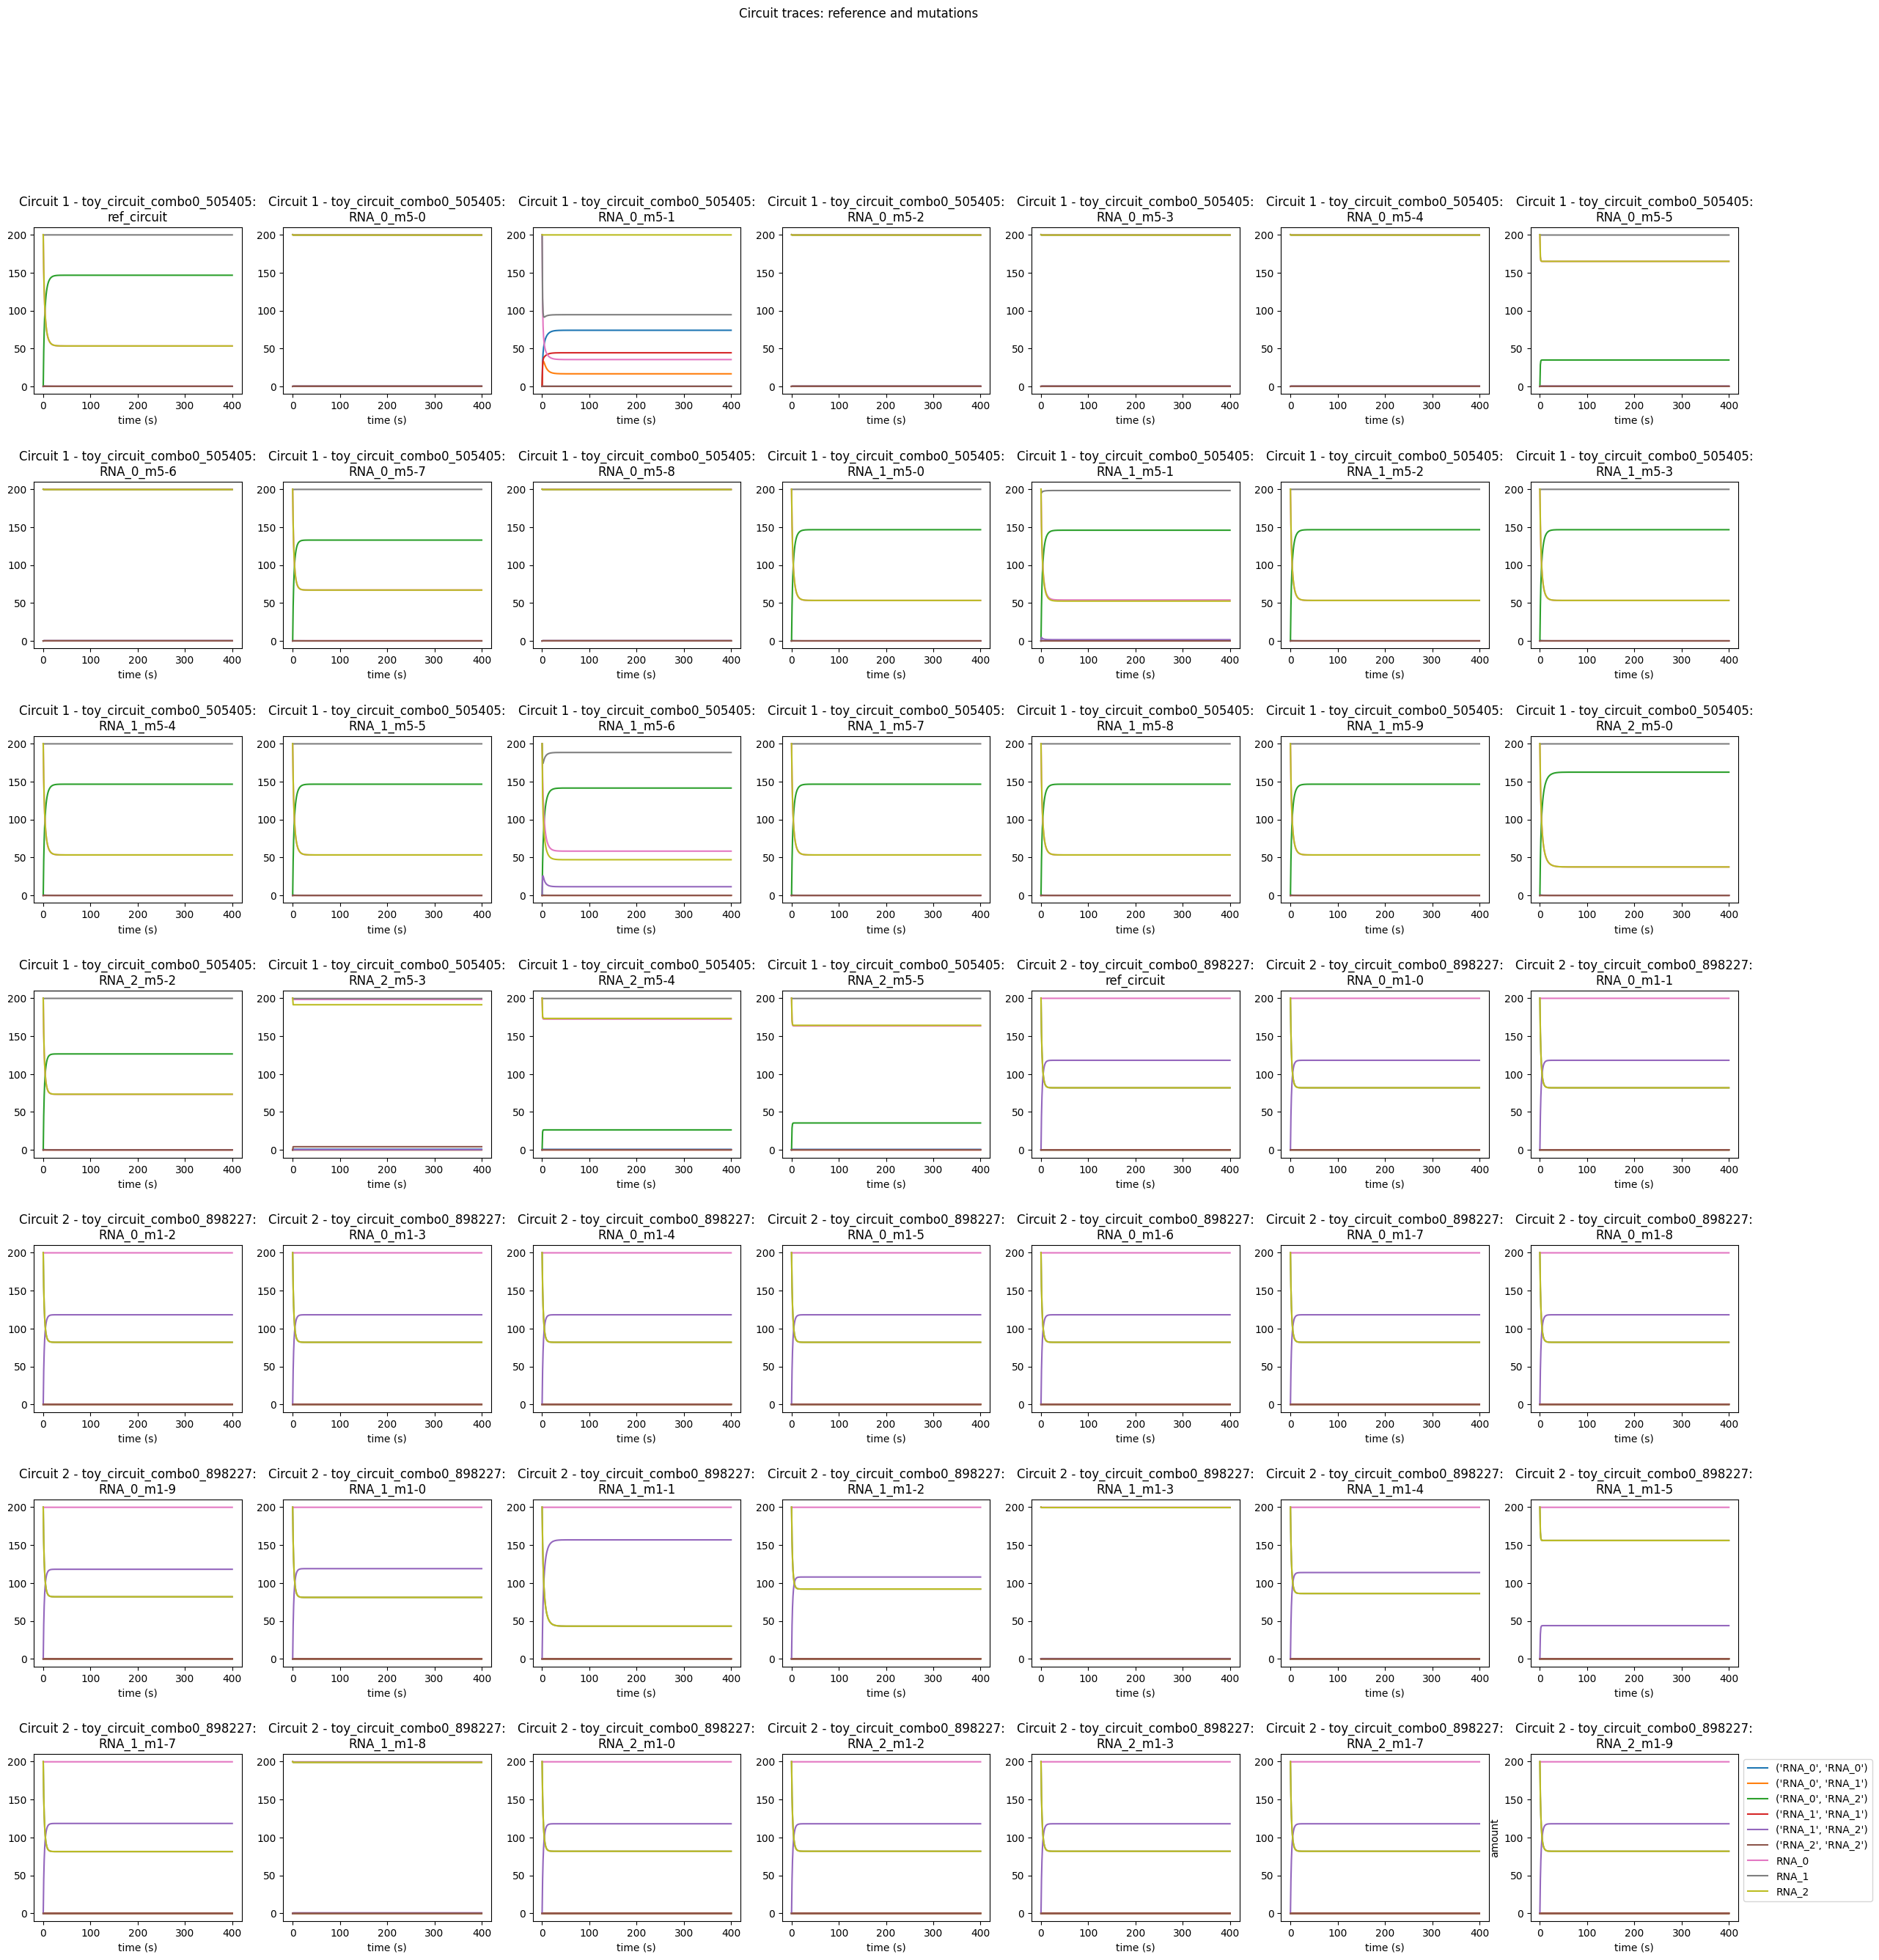

In [42]:
num_circuits = len(circuits)
nm=0
fig = plt.figure(figsize=(30, 30))
fig.subplots_adjust(hspace=0.525)
for i, circ in enumerate(circuits):
    ax = plt.subplot(7,7,i+1)
    plt.plot(np.concatenate([tss, tyy + tss[-1]]), np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T]))
    circ_type = 'Circuit 2' if circ in circuits2 else 'Circuit 1'
    plt.title(f'{circ_type} - {circuits[i].name}:\n{circuits[i].subname}')
    plt.xlabel('time (s)')
plt.legend([s.name for s in circuits[0].model.species], loc='upper right')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
plt.ylabel('amount')

plt.suptitle('Circuit traces: reference and mutations')
